In [6]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml 

# EXP_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_experiment_clients.txt" 
# DEMO_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_demo.txt"    
# ZIP_PATH  = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_web_data_pt_.zip"       
# EXTRACT_DIR = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/rawwebdata_extracted"            
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

df_demo = pd.read_csv(config['input_data']['file1'])

In [25]:
# 1) Load & merge datasets

# 1.1 Experiment (client_id -> Variation)
df_exp = pd.read_csv(EXP_PATH)
df_exp = df_exp[df_exp["Variation"].isin(["Test", "Control"])].copy()

# 1.2 Demographics (client_id -> clnt_age)
df_demo = pd.read_csv(DEMO_PATH)

assert "clnt_age" in df_demo.columns, "Age column 'clnt_age' not found in df_final_demo.txt"

# 1.3 Web logs
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

web_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".txt")]
frames = [pd.read_csv(os.path.join(EXTRACT_DIR, f), parse_dates=["date_time"]) for f in web_files]
dw = pd.concat(frames, ignore_index=True)

# 1.4 Anexa Variation (via client_id) e mantém só Test/Control
dw = dw.merge(df_exp[["client_id","Variation"]], on="client_id", how="inner")
dw = dw[dw["Variation"].isin(["Test","Control"])].copy()

# 1.5 Anexa idade (clnt_age) ao evento via client_id
dw = dw.merge(df_demo[["client_id","clnt_age"]], on="client_id", how="left")


print("Rows:", len(dw))
print("Unique visitors:", dw["visitor_id"].nunique())
print("Process steps found:", sorted(dw["process_step"].unique()))


Rows: 321309
Unique visitors: 56011
Process steps found: ['confirm', 'start', 'step_1', 'step_2', 'step_3']


In [26]:
# 2) Remove clients who are in both groups


visitors_test = set(dw.loc[dw["Variation"]=="Test", "visitor_id"].unique())
visitors_ctrl = set(dw.loc[dw["Variation"]=="Control", "visitor_id"].unique())

dual_visitors = visitors_test & visitors_ctrl  # interseção = estão nos dois
print("Visitors in BOTH groups (will be excluded):", len(dual_visitors))

dw_test_excl = dw[(dw["Variation"]=="Test") & (~dw["visitor_id"].isin(dual_visitors))].copy()
dw_ctrl_excl = dw[(dw["Variation"]=="Control") & (~dw["visitor_id"].isin(dual_visitors))].copy()

print("Exclusive Test visitors:", dw_test_excl["visitor_id"].nunique())
print("Exclusive Control visitors:", dw_ctrl_excl["visitor_id"].nunique())


Visitors in BOTH groups (will be excluded): 185
Exclusive Test visitors: 29734
Exclusive Control visitors: 26092


In [27]:
# 3) Create 10-year age bands starting from the REAL minimum


# Idade mínima e máxima nos dados exclusivos
min_age = float(pd.concat([dw_test_excl["clnt_age"], dw_ctrl_excl["clnt_age"]]).min())
max_age = float(pd.concat([dw_test_excl["clnt_age"], dw_ctrl_excl["clnt_age"]]).max())

# Décadas: piso para mínimo, teto para máximo (+10 para cobrir o intervalo final)
floor_min = int(np.floor(min_age/10.0)*10)
ceil_max  = int(np.ceil(max_age/10.0)*10)

# Constrói bins a cada 10 anos
bins = list(range(floor_min, ceil_max+10, 10)) 

# Labels "10-19", "20-29"...
labels = [f"{start}-{end-1}" for start, end in zip(bins[:-1], bins[1:])]

def add_age_band(df, age_col="clnt_age"):
    """Adds a categorical 'age_band' column using 10-year bins."""
    out = df.copy()
    out["age_band"] = pd.cut(out[age_col], bins=bins, labels=labels, right=False, include_lowest=True)
    return out

dw_test_excl = add_age_band(dw_test_excl)
dw_ctrl_excl = add_age_band(dw_ctrl_excl)

print("Age bands:", dw_test_excl["age_band"].dropna().unique().tolist())


Age bands: ['70-79', '30-39', '40-49', '20-29', '50-59', '60-69', '10-19', '80-89', '90-99']


In [28]:
# 4) Optimized compute_visit_durations 

def compute_visit_durations(df):
    # Keep only relevant columns
    df_sorted = df[["visit_id","visitor_id","Variation","age_band","process_step","date_time"]].copy()
    df_sorted = df_sorted.sort_values(["visit_id", "date_time"])

    # Take the first occurrence of each step per visit_id
    first_steps = (
        df_sorted
        .drop_duplicates(subset=["visit_id","process_step"], keep="first")
        .pivot(index="visit_id", columns="process_step", values="date_time")
    )

    # Reattach visitor_id, Variation, age_band (take first per visit)
    meta = (
        df_sorted.groupby("visit_id")[["visitor_id","Variation","age_band"]]
        .first()
    )

    # Combine meta + steps
    wide = meta.join(first_steps)

    def minutes_between(a, b):
        if pd.isna(a) or pd.isna(b):
            return np.nan
        return (b - a).total_seconds() / 60.0

    per_visit = wide.copy()
    per_visit["t_start_to_step_1"]   = per_visit.apply(lambda r: minutes_between(r.get("start"),   r.get("step_1")),   axis=1)
    per_visit["t_step_1_to_step_2"]  = per_visit.apply(lambda r: minutes_between(r.get("step_1"),  r.get("step_2")),  axis=1)
    per_visit["t_step_2_to_step_3"]  = per_visit.apply(lambda r: minutes_between(r.get("step_2"),  r.get("step_3")),  axis=1)
    per_visit["t_step_3_to_confirm"] = per_visit.apply(lambda r: minutes_between(r.get("step_3"),  r.get("confirm")), axis=1)
    per_visit["t_start_to_confirm"]  = per_visit.apply(lambda r: minutes_between(r.get("start"),   r.get("confirm")), axis=1)
    per_visit["completed"]           = per_visit["confirm"].notna().astype(int)

    # Reset index so visit_id becomes a column
    per_visit = per_visit.reset_index()

    return per_visit


In [29]:
# 5) Compute per-visit durations for EXCLUSIVE Test & Control

per_visit_test  = compute_visit_durations(dw_test_excl)
per_visit_ctrl  = compute_visit_durations(dw_ctrl_excl)

print("Visits (exclusive Test):",  per_visit_test["visit_id"].nunique())
print("Visits (exclusive Control):", per_visit_ctrl["visit_id"].nunique())


Visits (exclusive Test): 36918
Visits (exclusive Control): 31970


In [39]:
# Compute mean durations by age band & group
# Keep only formatted mm:ss columns for clean output

METRICS = [
    "t_start_to_step_1",
    "t_step_1_to_step_2",
    "t_step_2_to_step_3",
    "t_step_3_to_confirm",
    "t_start_to_confirm"
]

def mean_by_ageband(df_per_visit):
    """
    Group by (Variation, age_band) and calculate the mean of the duration metrics.
    """
    grp = (
        df_per_visit
        .groupby(["Variation", "age_band"], observed=True)[METRICS]
        .mean()
        .reset_index()
    )
    return grp

# Compute group means for Test and Control separately
test_by_age = mean_by_ageband(per_visit_test)
ctrl_by_age = mean_by_ageband(per_visit_ctrl)

# Merge for side-by-side comparison
by_age_all = pd.concat([test_by_age, ctrl_by_age], ignore_index=True)
by_age_all = by_age_all.sort_values(["age_band", "Variation"]).reset_index(drop=True)

# Numeric version for plotting
by_age_all_fmt = by_age_all.copy()
for col in METRICS:
    by_age_all_fmt[col] = by_age_all_fmt[col].round(2)
    
# Convert all metric columns to mm:ss format and keep only those

def format_mmss(minutes):
    """Convert decimal minutes to mm:ss string format."""
    if pd.isna(minutes):
        return ""
    m = int(minutes)
    s = int(round((minutes - m) * 60))
    return f"{m:02d}:{s:02d}"

# Create a new DataFrame with only Variation, age_band, and formatted metrics
formatted_df = by_age_all[["Variation", "age_band"]].copy()

for col in METRICS:
    formatted_df[col] = by_age_all[col].apply(format_mmss)

print("=== Mean duration by age band & group (mm:ss) ===")
display(formatted_df.head(20))  # exibe primeiras linhas formatadas


=== Mean duration by age band & group (mm:ss) ===


,Variation,age_band,t_start_to_step_1,t_step_1_to_step_2,t_step_2_to_step_3,t_step_3_to_confirm,t_start_to_confirm
0,Control,10-19,00:49,00:21,01:46,02:14,05:06
1,Test,10-19,00:43,01:13,01:40,01:30,04:54
2,Control,20-29,00:42,00:34,01:48,01:57,05:04
3,Test,20-29,00:40,01:04,01:42,01:25,04:47
4,Control,30-39,00:45,00:34,01:54,02:04,05:20
5,Test,30-39,00:42,01:05,01:44,01:27,04:56
6,Control,40-49,01:06,00:45,02:09,02:25,06:13
7,Test,40-49,00:47,01:12,02:08,01:56,05:60
8,Control,50-59,01:09,00:57,02:10,03:11,07:30
9,Test,50-59,00:53,01:23,02:10,02:50,07:16


In [40]:
# 7) Overall group means (independent of age)

overall_test = per_visit_test.groupby("Variation")[METRICS].mean().reset_index()
overall_ctrl = per_visit_ctrl.groupby("Variation")[METRICS].mean().reset_index()
overall_all  = pd.concat([overall_test, overall_ctrl], ignore_index=True).sort_values("Variation")

print("=== Overall (all ages) mean durations by group (minutes) ===")
overall_all


=== Overall (all ages) mean durations by group (minutes) ===


,Variation,t_start_to_step_1,t_step_1_to_step_2,t_step_2_to_step_3,t_step_3_to_confirm,t_start_to_confirm
1,Control,1.062374,0.835900,1.829428,2.814678,6.525791
0,Test,0.857916,1.259717,1.792759,2.384113,6.240226


In [47]:
# Function to plot a single metric by age band and variation
#  Plots a bar chart comparing Test vs Control by age band for a given metric.
    
def plot_by_age_band(df, metric, title):
    # Pivot table for easy plotting
    pivot = df.pivot(index="age_band", columns="Variation", values=metric)
    pivot = pivot.reindex(index=sorted(pivot.index, key=lambda x: str(x)))

    x = np.arange(len(pivot.index))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, pivot["Test"], width, label="Test")
    ax.bar(x + width/2, pivot["Control"], width, label="Control")

    ax.set_xlabel("Age band")
    ax.set_ylabel("Mean time (minutes)")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()

# ==========================================================
# Titles dictionary for each metric
# - Use these keys to select which chart you want to plot
# ==========================================================
plot_titles = {
    "t_start_to_step_1": "Start → Step 1",
    "t_step_1_to_step_2": "Step 1 → Step 2",
    "t_step_2_to_step_3": "Step 2 → Step 3",
    "t_step_3_to_confirm": "Step 3 → Confirm",
    "t_start_to_confirm": "Start → Confirm (Total)"
}


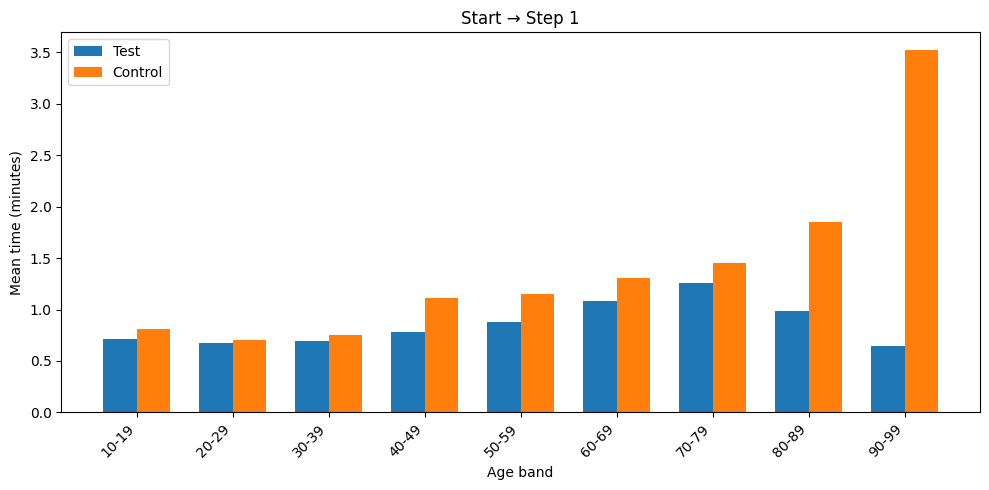

In [48]:
plot_by_age_band(
    by_age_all_fmt,
    "t_start_to_step_1",
    "Start → Step 1"
)


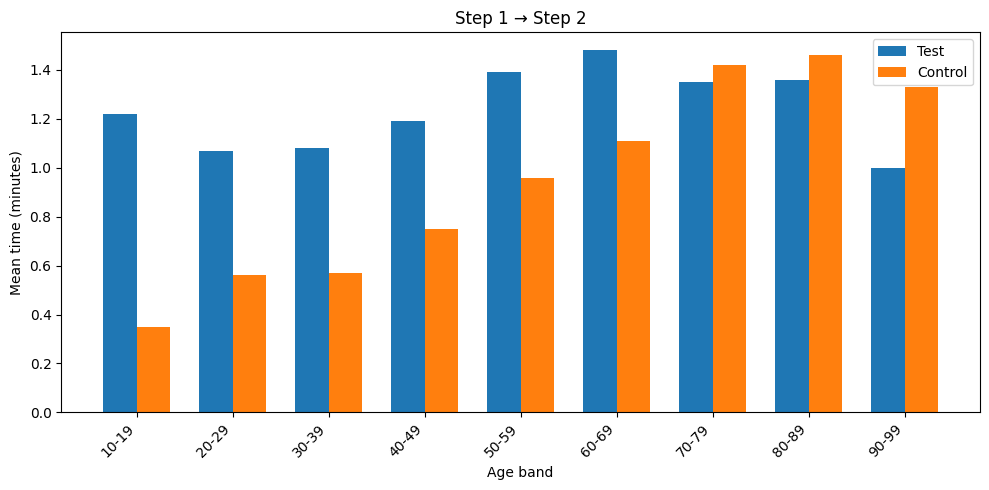

In [49]:
plot_by_age_band(
    by_age_all_fmt,
    "t_step_1_to_step_2",
    "Step 1 → Step 2"
)


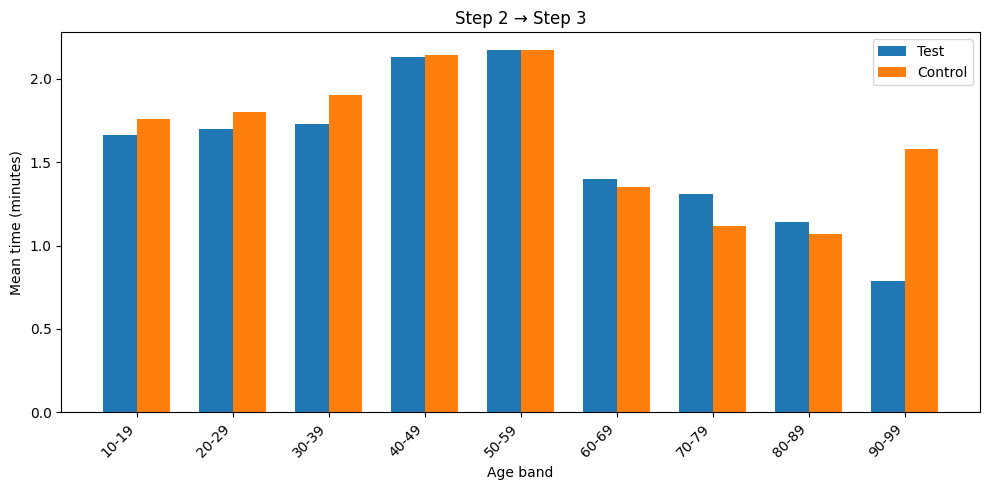

In [44]:
plot_by_age_band(
    by_age_all_fmt,
    "t_step_2_to_step_3",
    "Step 2 → Step 3"
)


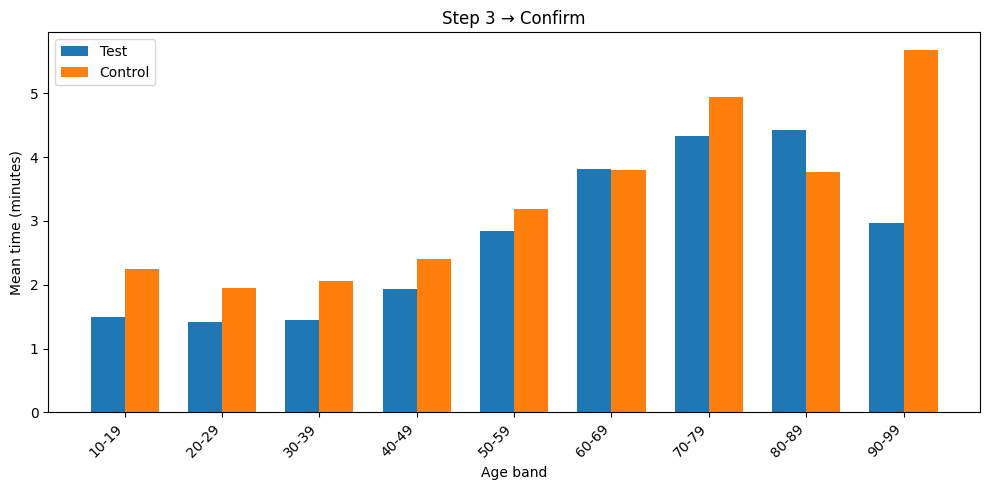

In [45]:
plot_by_age_band(
    by_age_all_fmt,
    "t_step_3_to_confirm",
    "Step 3 → Confirm"
)


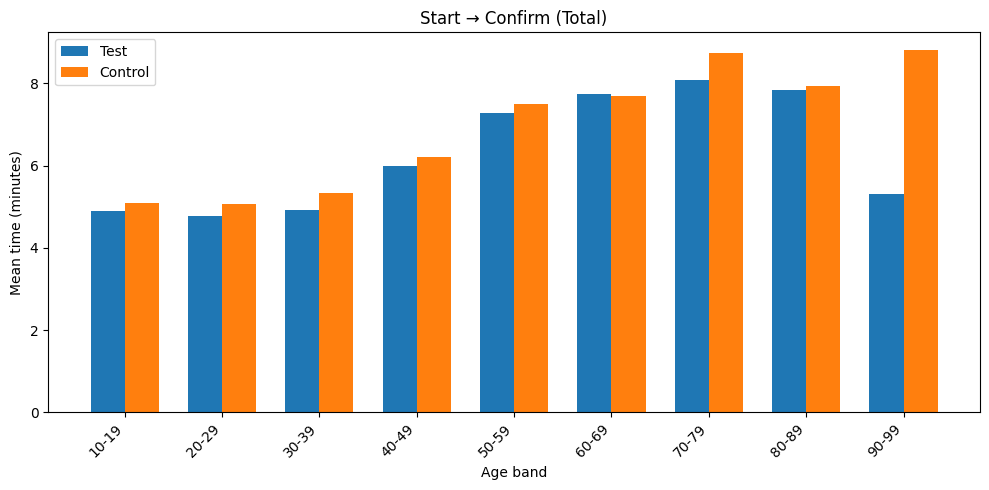

In [46]:
plot_by_age_band(
    by_age_all_fmt,
    "t_start_to_confirm",
    "Start → Confirm (Total)"
)
